# Simulation of Option Hedging

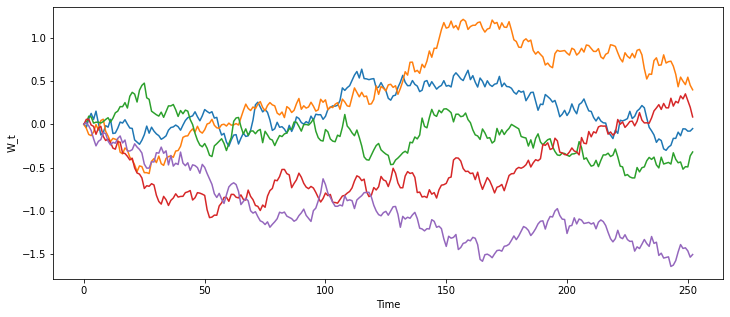

In [1]:
# Q1 a
import numpy as np
import matplotlib.pyplot as plt

def simulate_Wt(k, n=252):
    z = np.random.normal(0, 1, (k,n))
    result = []
    for i in range(k):
        path = [0]
        for j in range(n):
            path.append(path[-1]+z[i][j]*np.sqrt(1/n))
        result.append(path)
    return result
  
# test
paths = simulate_Wt(5)
plt.figure(figsize=(12, 5))
for i in range(5):
    plt.plot(paths[i])
plt.xlabel("Time")
plt.ylabel("W_t")
plt.show()

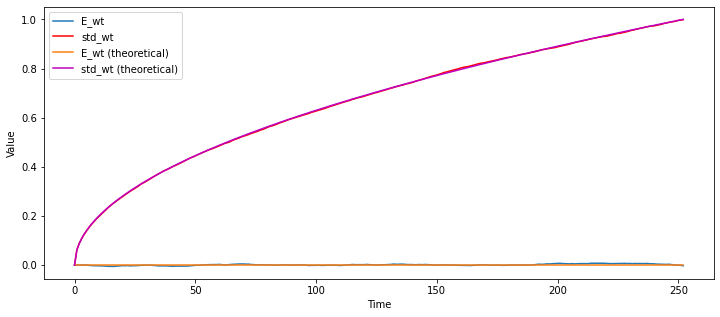

In [2]:
# Q1 b
brownian_paths = np.array(simulate_Wt(10000))
E_wt = brownian_paths.mean(axis=0)
std_wt = brownian_paths.std(axis=0)
# Q1 c
plt.figure(figsize=(12, 5))
l1, = plt.plot(E_wt)
l2, = plt.plot(std_wt,color='r')
l3, = plt.plot([0 for i in range(253)])
l4, = plt.plot([np.sqrt(i/252) for i in range(253)], color='m')
plt.xlabel("Time")
plt.ylabel("Value")
# E(Wt) and std(Wt) at each time step 
plt.legend(handles=[l1,l2,l3,l4],labels=['E_wt','std_wt','E_wt (theoretical)','std_wt (theoretical)']) 
plt.show()

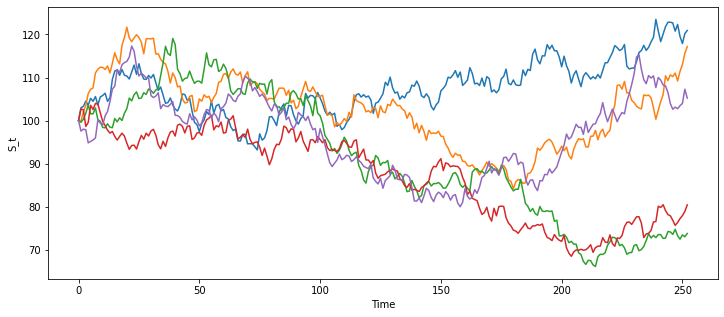

In [3]:
# Q2 
def simulate_St(k, n=252,s0=100,mu=0.03,sigma=0.25):
    z = np.random.normal(0, 1, (k,n))
    result = []
    for i in range(k):
        path = [100]
        for j in range(n):
            path.append(path[-1]*np.exp((mu-1/2*sigma**2)*1/n+sigma*np.sqrt(1/n)*z[i][j]))
        result.append(path)
    return result

# test
paths = simulate_St(5)
plt.figure(figsize=(12, 5))
for i in range(5):
    plt.plot(paths[i])
plt.xlabel("Time")
plt.ylabel("S_t")
plt.show()

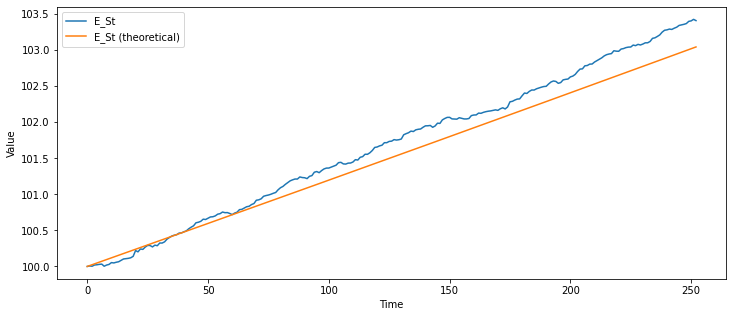

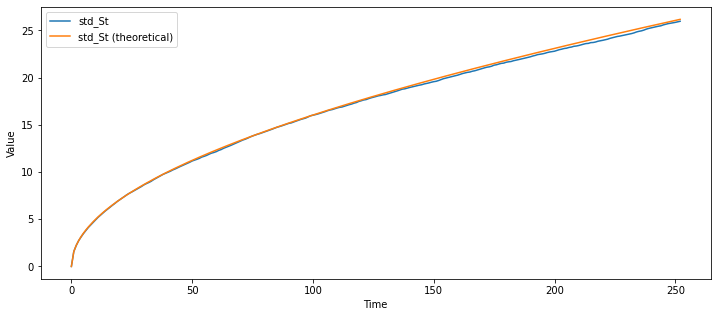

In [4]:
stock_paths = np.array(simulate_St(10000))
E_st = stock_paths.mean(axis=0)
std_st = stock_paths.std(axis=0)
plt.figure(figsize=(12, 5))
l1, = plt.plot(E_st)
l2, = plt.plot([100*np.exp(0.03*i/252) for i in range(253)])
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend(handles=[l1,l2],labels=['E_St','E_St (theoretical)']) 
plt.show()

plt.figure(figsize=(12, 5))
l3, = plt.plot(std_st)
# std of S_t is S_0*exp((mu-sigma^2/2)*t)*sqrt(exp(2sigma^2t)-exp(sigma^2t))
l4, = plt.plot([100*np.exp((0.03-0.25**2/2)*i/252)*np.sqrt(np.exp(2*0.25**2*i/252)-np.exp(0.25**2*i/252)) for i in range(253)])
plt.legend(handles=[l3,l4],labels=['std_St','std_St (theoretical)']) 
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

# Q3
In order to simulate the values of the hedging portfolio, note that the initial capital we start with is the price of the European call option, and the number of stocks we hold is the $\Delta$ of the option and we finance this position with the risk free money account. We can calculate the $\Delta$ from the BS formula and we change our position at the end of each day. Note that the change of position will not change the value of our wealth, and changes only comes from the changes in the stock price and the interest comes from the money account. 

In [5]:
from scipy.stats import norm
import numpy as np

def black_scholes(S, K, T, r, sigma):
    """
    Calculate the Black-Scholes option price.

    Parameters:
    S (float): Current stock price
    K (float): Option strike price
    T (float): Time to expiration (in years)
    r (float): Risk-free interest rate
    sigma (float): Volatility of the underlying stock
    Returns:
    float: Black-Scholes option price
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    option_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return option_price

def get_delta(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

# (a) & (b)
def simulate_portf(ind):
    stock = stock_paths[ind]
    initial_capital = black_scholes(100,100,1,0.05,0.25)
    portf = [initial_capital]
    for i in range(252):
        delta = get_delta(stock[i],100,1-i/252,0.05,0.25)
        portf.append(delta*stock[i+1]+(portf[-1]-delta*stock[i])*(1+0.05/252))

    BS_path = []
    for i in range(252):
        BS_path.append(black_scholes(stock[i],100,1-i/252,0.05,0.25))
    BS_path.append(max(0,stock[-1]-100))

    plt.figure(figsize=(12, 5))
    l1, = plt.plot(portf)
    l2, = plt.plot(BS_path)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend(handles=[l1,l2],labels=['Portf','BS_path']) 
    plt.show()

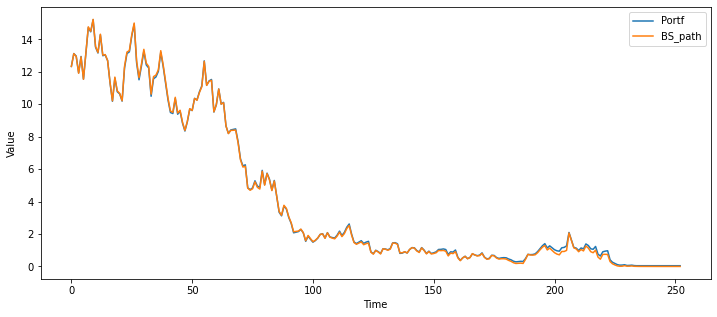

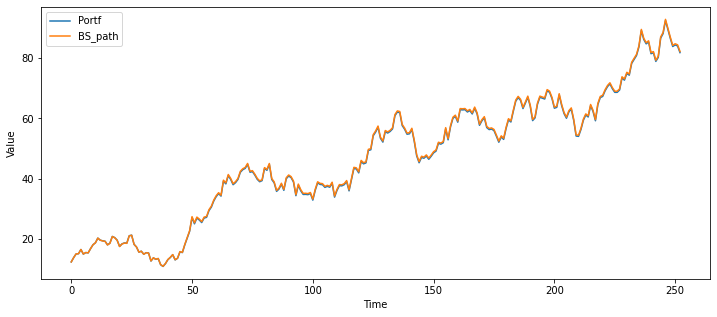

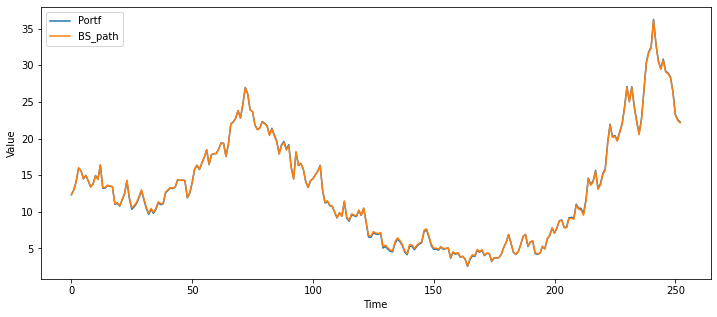

In [6]:
for ind in range(3):
    simulate_portf(ind)

#### We can see that the hedging portfolio approximates the Black-Scholes very well. 

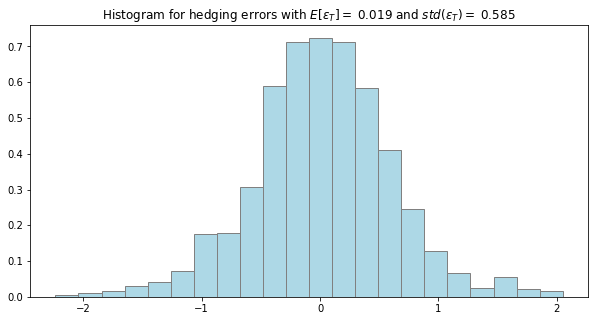

In [7]:
# Q3 (c)
def simulate_error(ind):
    stock = stock_paths[ind]
    initial_capital = black_scholes(100,100,1,0.05,0.25)
    portf = [initial_capital]
    for i in range(252):
        delta = get_delta(stock[i],100,1-i/252,0.05,0.25)
        portf.append(delta*stock[i+1]+(portf[-1]-delta*stock[i])*(1+0.05/252))

    BS_path = []
    for i in range(252):
        BS_path.append(black_scholes(stock[i],100,1-i/252,0.05,0.25))
    BS_path.append(max(0,stock[-1]-100))
    return portf[-1] - BS_path[-1]    # return the hedging error

err = []
for i in range(1000):
    err.append(simulate_error(i))
plt.figure(figsize=(10, 5))
plt.hist(
    err,
    density=True,
    color="lightblue",
    edgecolor="grey",
    bins="scott",
)
mean = round(np.mean(err),3)
std = round(np.std(err),3)
plt.title("Histogram for hedging errors with $E[\epsilon_T] = $ {} and $std(\epsilon_T) = $ {}".format(mean,std))
plt.show()

In [8]:
# Q4 (a)
def simulate_error_advanced(mu,n,sigma): # n = 252, 52, 16
    stock_paths = simulate_St(1000,n,mu=mu,sigma=sigma)
    err = []
    for ind in range(1000):
        stock = stock_paths[ind]
        initial_capital = black_scholes(100,100,1,0.05,sigma)
        portf = [initial_capital]
        for i in range(n):
            delta = get_delta(stock[i],100,1-i/n,0.05,sigma)
            portf.append(delta*stock[i+1]+(portf[-1]-delta*stock[i])*(1+0.05/n))
        BS_path = []
        for i in range(n):
            BS_path.append(black_scholes(stock[i],100,1-i/n,0.05,sigma))
        BS_path.append(max(0,stock[-1]-100))
        err.append(portf[-1] - BS_path[-1]) 
    plt.figure(figsize=(10, 5))
    plt.hist(
    err,
    density=True,
    color="lightblue",
    edgecolor="grey",
    bins="scott",
    )
    mean = round(np.mean(err),3)
    std = round(np.std(err),3)
    print("When delta_t = 1/{}, mu = {} and sigma = {}: ".format(n, mu, sigma))
    plt.title("Histogram for hedging errors with $E[\epsilon_T] = $ {} and $std(\epsilon_T) = $ {}".format(mean,std))
    plt.show()

When delta_t = 1/52, mu = 0.05 and sigma = 0.3: 


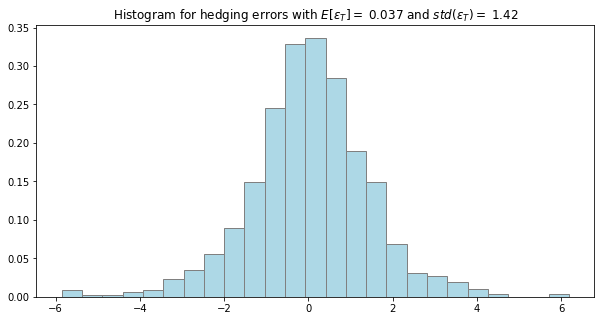

When delta_t = 1/16, mu = 0.05 and sigma = 0.3: 


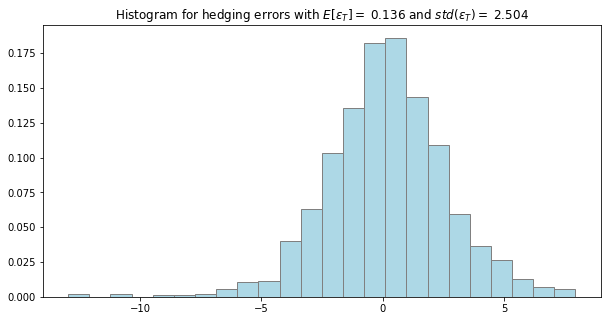

When delta_t = 1/52, mu = 0.05 and sigma = 0.45: 


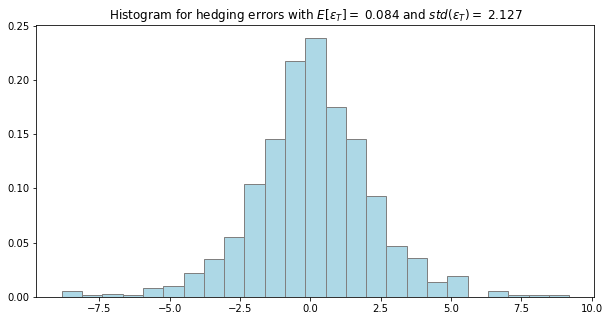

When delta_t = 1/16, mu = 0.05 and sigma = 0.45: 


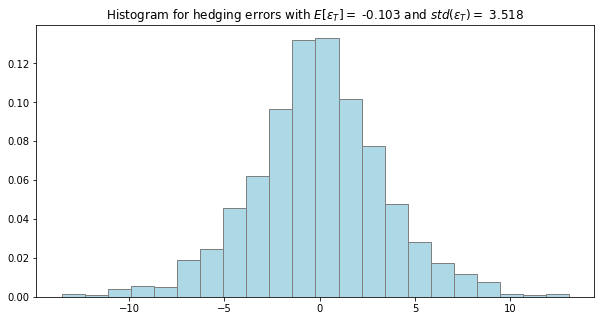

When delta_t = 1/52, mu = 0.05 and sigma = 0.6: 


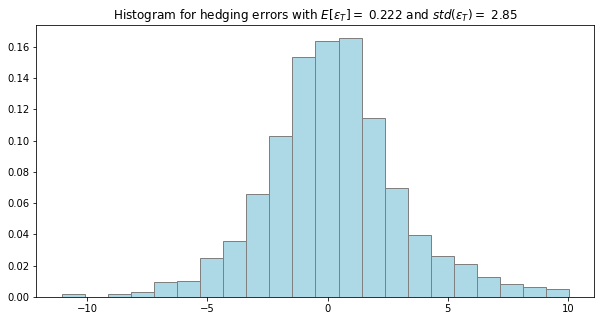

When delta_t = 1/16, mu = 0.05 and sigma = 0.6: 


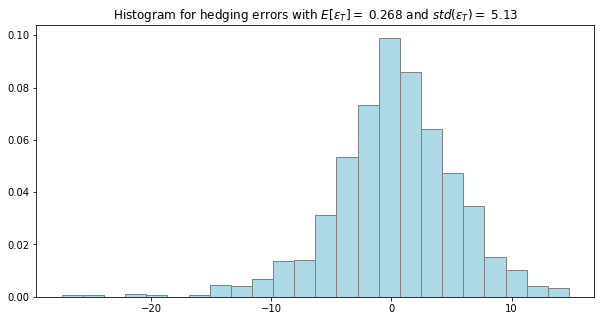

When delta_t = 1/52, mu = 0.05 and sigma = 0.8: 


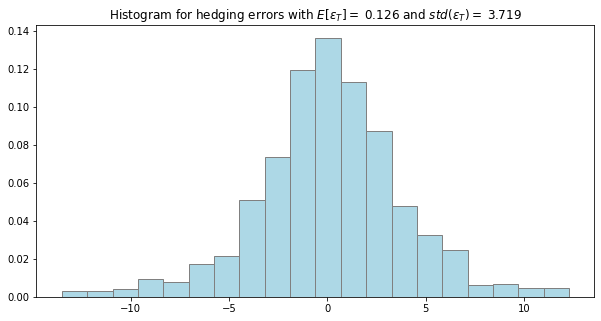

When delta_t = 1/16, mu = 0.05 and sigma = 0.8: 


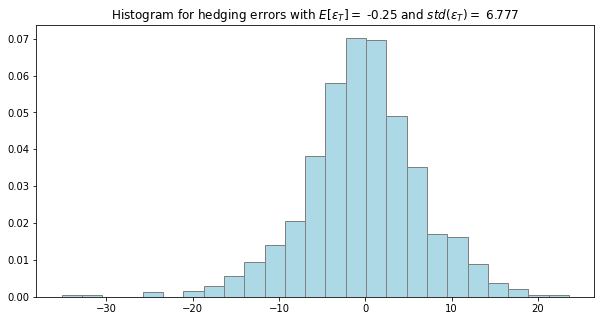

When delta_t = 1/52, mu = 0.1 and sigma = 0.3: 


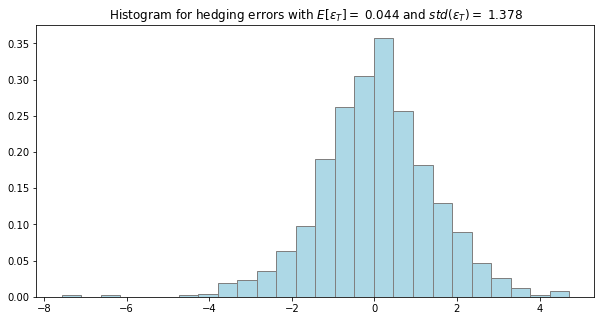

When delta_t = 1/16, mu = 0.1 and sigma = 0.3: 


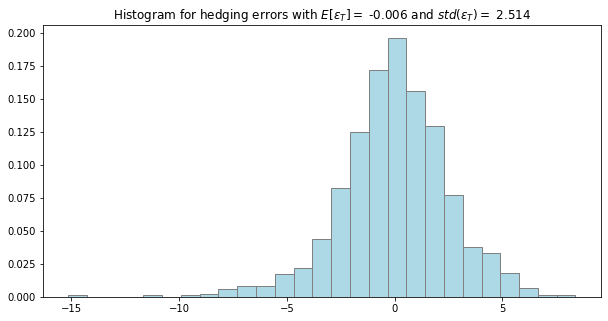

When delta_t = 1/52, mu = 0.1 and sigma = 0.45: 


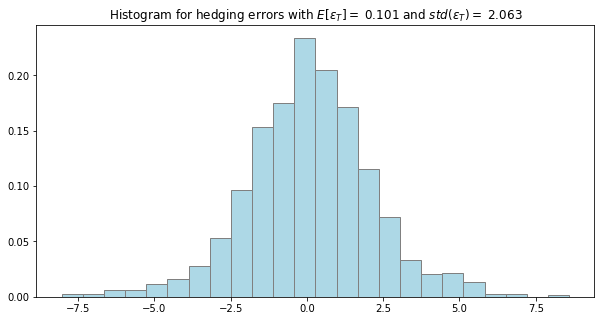

When delta_t = 1/16, mu = 0.1 and sigma = 0.45: 


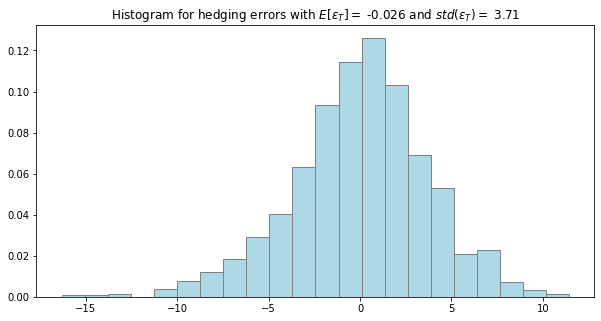

When delta_t = 1/52, mu = 0.1 and sigma = 0.6: 


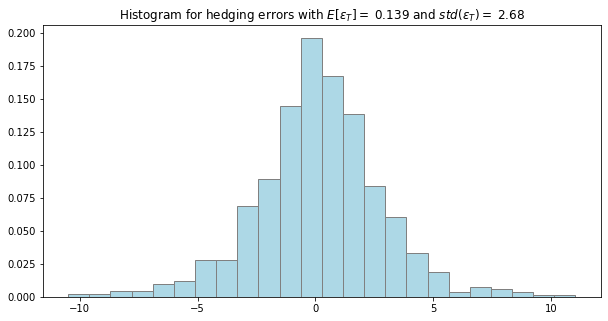

When delta_t = 1/16, mu = 0.1 and sigma = 0.6: 


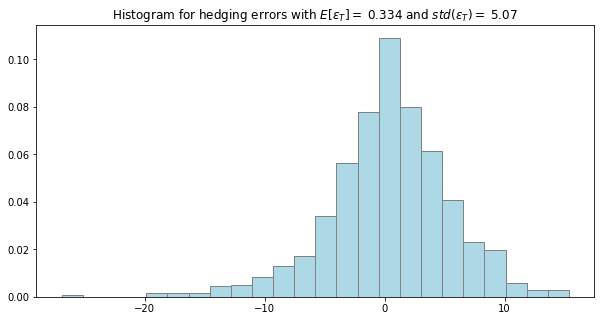

When delta_t = 1/52, mu = 0.1 and sigma = 0.8: 


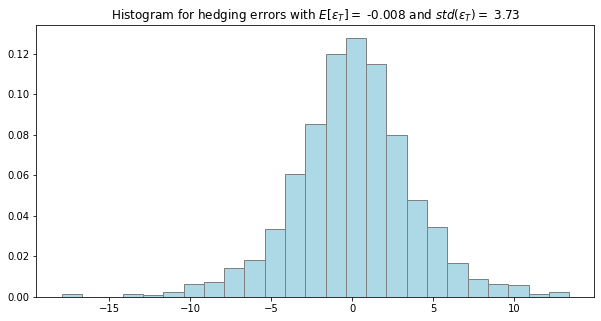

When delta_t = 1/16, mu = 0.1 and sigma = 0.8: 


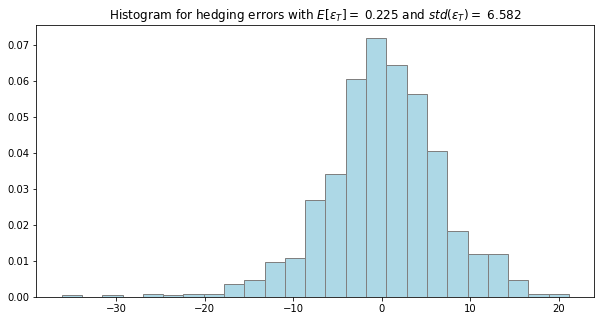

When delta_t = 1/52, mu = 0.15 and sigma = 0.3: 


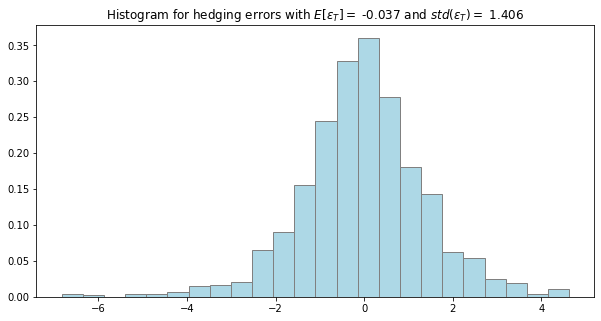

When delta_t = 1/16, mu = 0.15 and sigma = 0.3: 


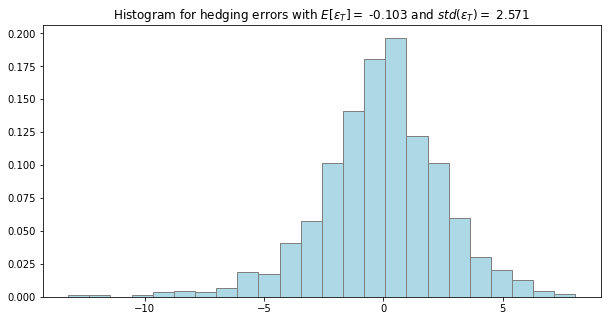

When delta_t = 1/52, mu = 0.15 and sigma = 0.45: 


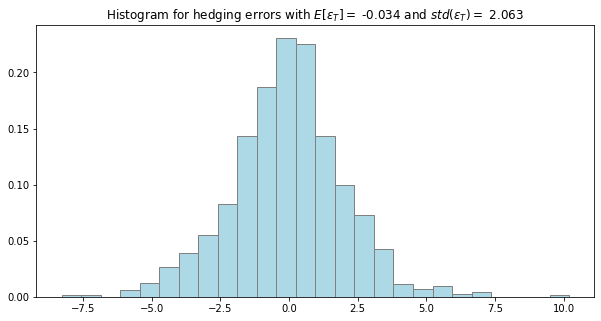

When delta_t = 1/16, mu = 0.15 and sigma = 0.45: 


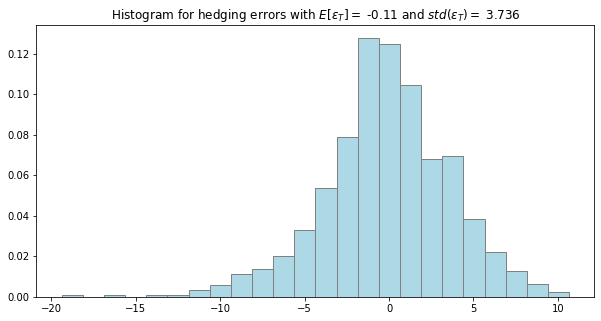

When delta_t = 1/52, mu = 0.15 and sigma = 0.6: 


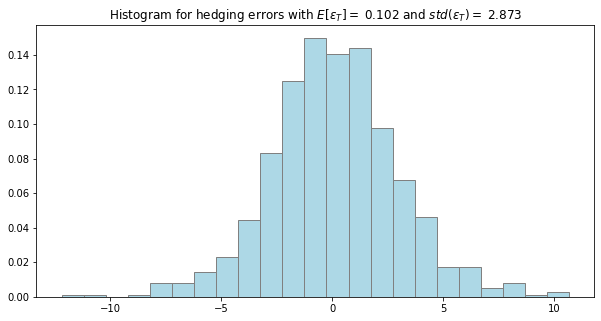

When delta_t = 1/16, mu = 0.15 and sigma = 0.6: 


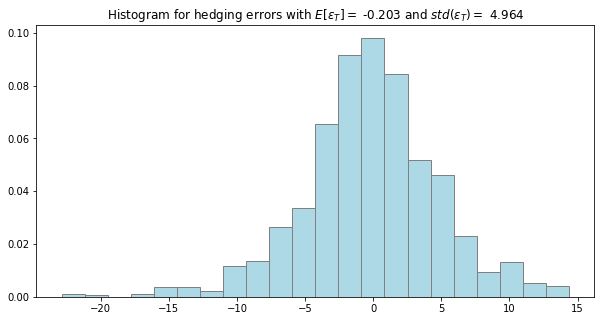

When delta_t = 1/52, mu = 0.15 and sigma = 0.8: 


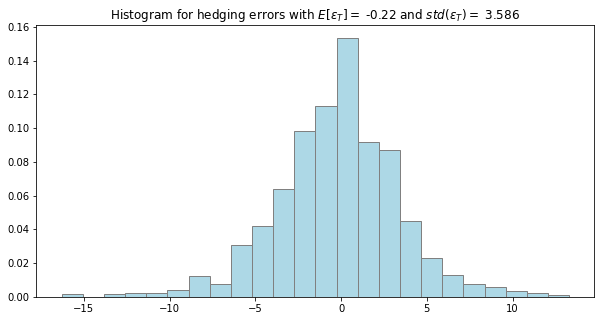

When delta_t = 1/16, mu = 0.15 and sigma = 0.8: 


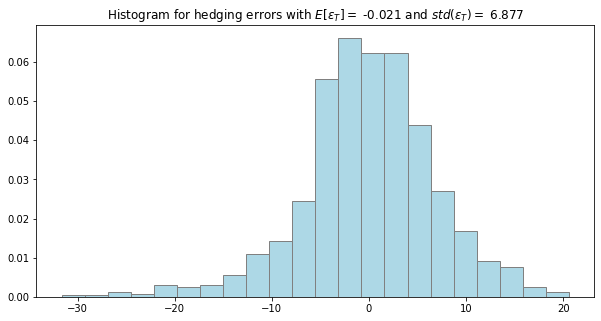

When delta_t = 1/52, mu = 0.2 and sigma = 0.3: 


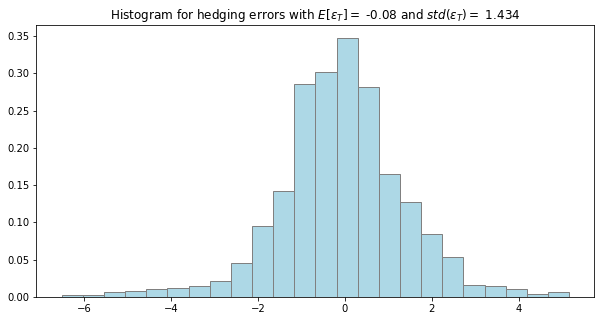

When delta_t = 1/16, mu = 0.2 and sigma = 0.3: 


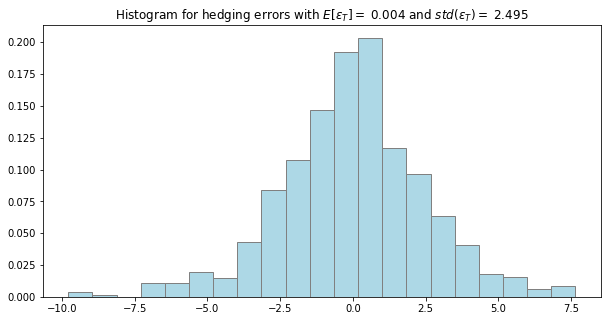

When delta_t = 1/52, mu = 0.2 and sigma = 0.45: 


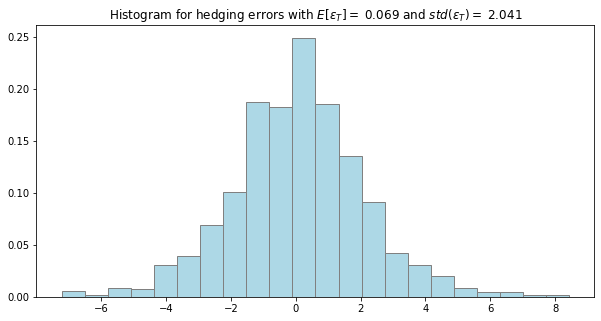

When delta_t = 1/16, mu = 0.2 and sigma = 0.45: 


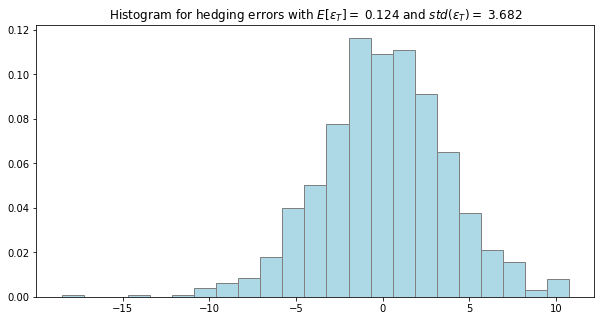

When delta_t = 1/52, mu = 0.2 and sigma = 0.6: 


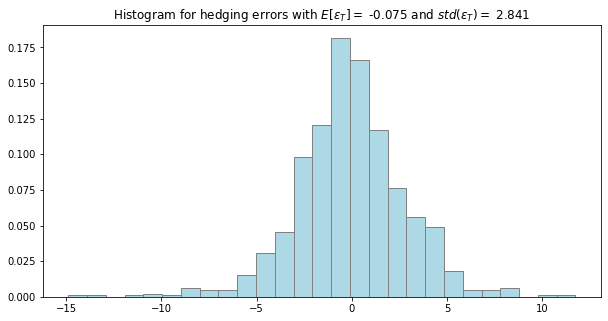

When delta_t = 1/16, mu = 0.2 and sigma = 0.6: 


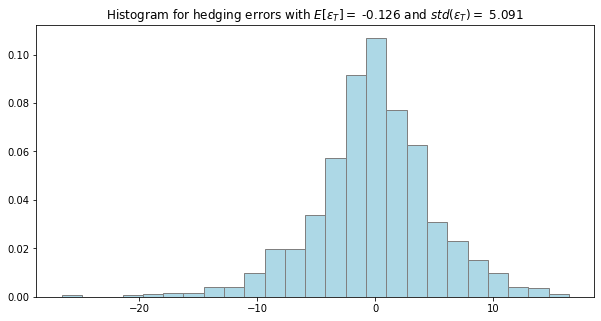

When delta_t = 1/52, mu = 0.2 and sigma = 0.8: 


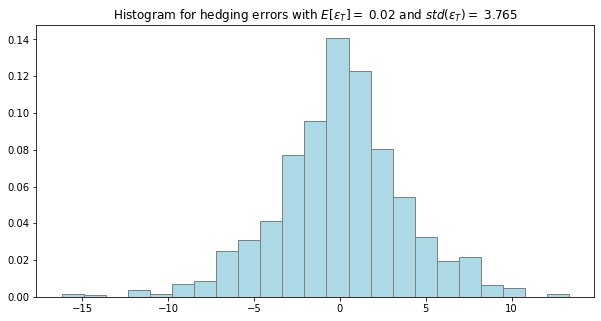

When delta_t = 1/16, mu = 0.2 and sigma = 0.8: 


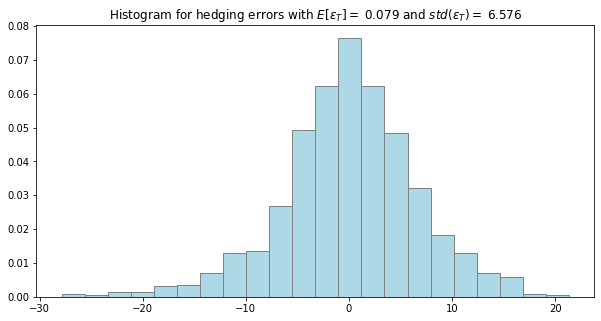

In [9]:
mu_list = [0.05,0.1,0.15,0.2]
sigma_list = [0.3,0.45,0.6,0.8]
for mu in mu_list:
    for sigma in sigma_list:
        simulate_error_advanced(mu,52,sigma)
        simulate_error_advanced(mu,16,sigma)

#### From the above diagrams, we can see that 
1) In all settings, the mean of the hedging error is close to 0;

2) When $\mu$ and $\sigma$ are fixed, as $\delta t$ increases, $Var(\epsilon)$ tends to increase, that is, the histogram would become more spread out;

3) When $\mu$ and $\delta t$ are fixed, as $\sigma$ increases, $Var(\epsilon)$ also tends to increase, that is, the histogram would become more spread out;

4) When $\sigma$ and $\delta t$ are fixed, as $\mu$ increases, $Var(\epsilon)$ is not impacted signficantly.

Q5 
(a)
\begin{equation*}
\begin{aligned}
dX_t &= \frac{1}{S_t}dS_t-\frac{1}{S_t^2}dS_tdS_t \\ 
&= (\mu -\sigma^2)dt + \sigma dW_t.
\end{aligned}
\end{equation*}
Therefore, we have $<X>_T = \int_0^T \sigma^2dt = \sigma^2T$.

In [10]:
# (b)
def his_vol(ind):
    X_t = np.log(stock_paths[ind])
    vol = []
    temp = 0
    for i in range(1, 253):
        temp += (X_t[i] - X_t[i-1])**2
        vol.append(np.sqrt(252*temp/i))
    plt.figure(figsize=(12, 5))
    l1, = plt.plot(vol)
    plt.xlabel("Time")
    plt.ylabel("Historical Volatility")
    plt.show()

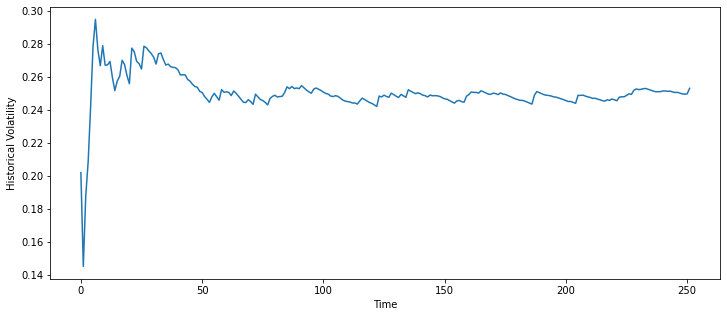

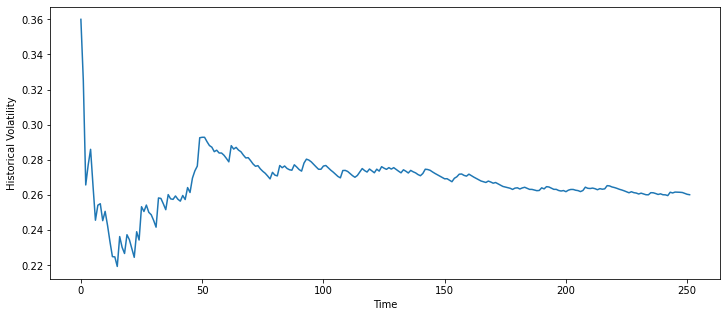

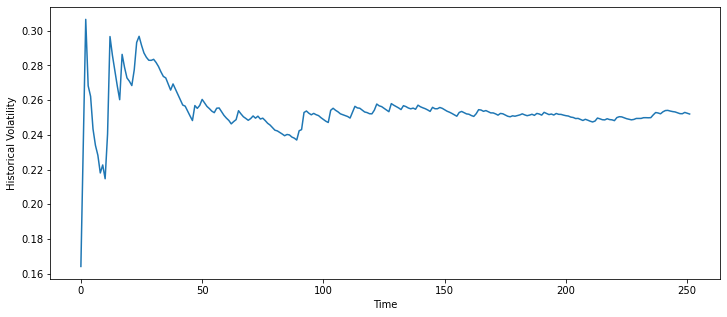

In [11]:
for ind in range(3):
    his_vol(ind)

We can see from the plot that as $n$ increases, the fluctuations in historical volatility tend to decrease, and it seems to converge in the long term.

In [12]:
# (c)
from scipy.optimize import fsolve

def BE_vol_distribution(ind):
    stock = stock_paths[ind]
    def solve_sigma(sigma):
        initial_capital = black_scholes(100,100,1,0.05,sigma)
        portf = [initial_capital]
        for i in range(252):
            delta = get_delta(stock[i],100,1-i/252,0.05,sigma)
            portf.append(delta*stock[i+1]+(portf[-1]-delta*stock[i])*(1+0.05/252))
        return portf[-1] - max(0,stock[-1]-100)
    ans = fsolve(solve_sigma, 0.25) 
    return ans

BE_vol = []
for ind in range(10000):
    BE_vol.append(BE_vol_distribution(ind)[0])

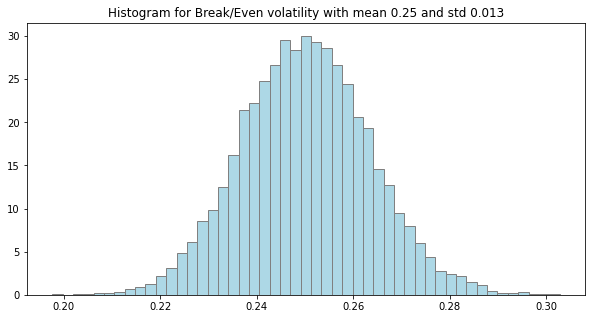

In [13]:
plt.figure(figsize=(10, 5))
plt.hist(
    BE_vol,
    density=True,
    color="lightblue",
    edgecolor="grey",
    bins="scott",
    )
mean = round(np.mean(BE_vol),3)
std = round(np.std(BE_vol),3)
plt.title("Histogram for Break/Even volatility with mean {} and std {}".format(mean,std))
plt.show()

Break/Even volatility seems to follow a bell-shaped distribution with mean 0.25 and variance $0.013^2$. It is kind of suprising that given 10000 different stock paths, the Break/Even volatility has such a small variance. 

# Hedging with Historical Data

In [96]:
import yfinance as yf
from dateutil import parser
from dateutil.relativedelta import relativedelta
from datetime import date


apple = yf.Ticker("AAPL")
start_date = "2020-08-01"
end_date = date.today().strftime("%Y-%m-%d")
hist_data = apple.history(start=start_date, end=end_date)
hist_data.index = hist_data.index.strftime('%Y-%m-%d')
hist_data = hist_data['Close']
tenor = 0.5   # T = 6M, 0.5Y

# Since risk free rate does not have a big effect on our result
# just take the average 3-month Treasury bill yield of our test period 
# as the risk free rate
treasury_bill = yf.Ticker("^IRX")
risk_free_data = treasury_bill.history(start=start_date, end=end_date)
# The yield is in percentage, convert it to decimal
rf = np.mean(risk_free_data['Close']) * 0.01

# test 500 hedging errors from 2021-1-4
def generator(ind, K):
    # calculate hedging error
    # get the testing stock data of 6 months
    ind += np.where(hist_data.index == '2021-01-04')[0][0]
    start_date = hist_data.index[ind]
    if K == "ATM":
        K = hist_data[ind]
    end_date = parser.parse(start_date) + relativedelta(months=6)
    end_date = end_date.strftime('%Y-%m-%d')
    stock = hist_data[(hist_data.index >= start_date) & (hist_data.index <= end_date)]
    # estimate the hedging volatility with log return of stock price during past 90 days 
    sigma =  np.log(hist_data[ind-90:ind]/hist_data[ind-90:ind].shift(1)).std() * np.sqrt(252)
    n = len(stock) - 1
    initial_capital = black_scholes(stock[0],K,tenor,rf,sigma)
    portf = [initial_capital]
    for i in range(n):
        # similarly, find the previous 90 days and calculate std of log return
        # to estimate hedging volatility
        indx = np.where(hist_data.index == stock.index[i])[0][0]
        pre_data = hist_data[indx-90:indx]
        log_returns = np.log(pre_data / pre_data.shift(1))
        sigma = log_returns.std() * np.sqrt(252)
        delta = get_delta(stock[i],K,tenor*(1-i/n),rf,sigma)
        portf.append(delta*stock[i+1]+(portf[-1]-delta*stock[i])*(1 + rf*tenor/n))
    err = portf[-1] - max(0,stock.iloc[-1]-K)
    # calculate B/E vol
    def solve_sigma(sig):
        portf_ = [initial_capital]
        for i in range(n):
            delta = get_delta(stock[i],K,tenor*(1-i/n),rf,sig)
            portf_.append(delta*stock[i+1]+(portf_[-1]-delta*stock[i])*(1 + rf*tenor/n))
        return portf_[-1] - max(0,stock.iloc[-1]-K)
    BE_vol = fsolve(solve_sigma, 0.3)[0]
    # calculate historical vol
    temp = 0
    log_St = np.log(stock)
    for i in range(n):
        temp += (log_St[i+1] - log_St[i])**2
    hist_vol = np.sqrt(temp/(n+1)*252)
    return err, BE_vol, hist_vol

In [97]:
import warnings
warnings.filterwarnings('ignore', 'The iteration is not making good progress')
def simulate_all(K_list):
    for k in K_list:
        err_list = []
        BE_vol_list = []
        hist_vol_list = []
        for i in range(600):
            err, BE_vol, hist_vol = generator(i, k)
            err_list.append(err)
            BE_vol_list.append(BE_vol)
            hist_vol_list.append(hist_vol)
        plt.figure(figsize=(10, 5))
        plt.hist(
            err_list,
            density=True,
            color="lightblue",
            edgecolor="grey",
            bins="scott",
            )
        mean = round(np.mean(err_list),3)
        std = round(np.std(err_list),3)
        plt.title("Histogram for hedging error with mean {} and std {}".format(mean,std)+", Stirke = "+str(k))
        plt.show()
        plt.figure(figsize=(12, 5))
        diff = np.subtract(np.array(BE_vol_list),np.array(hist_vol_list))
        plt.scatter(err_list, diff)
        plt.xlabel("Hedging error")
        plt.ylabel("Difference of B/E and historical vol")
        plt.show()
        plt.figure(figsize=(12, 5))
        l1, = plt.plot(BE_vol_list)
        l2, = plt.plot(hist_vol_list)
        plt.xlabel("Window")
        plt.ylabel("Volatility")
        plt.legend(handles=[l1,l2],labels=['B/E volatility','Historical Volatility'])
        plt.show()

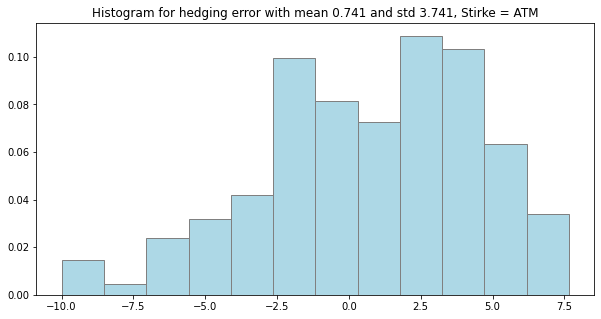

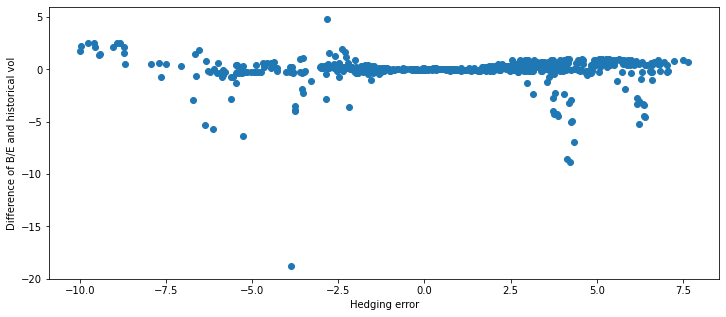

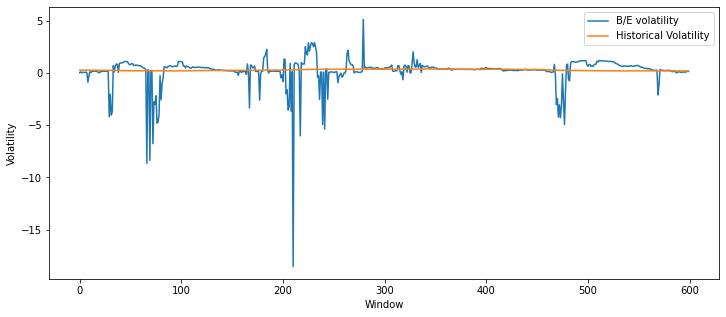

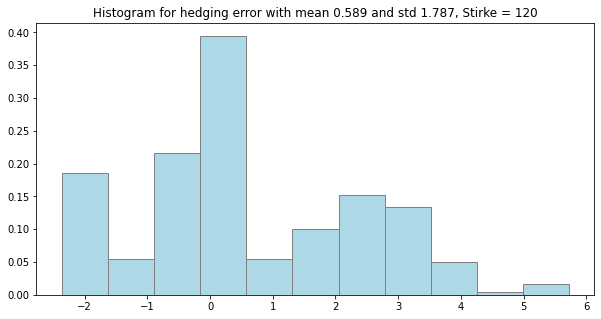

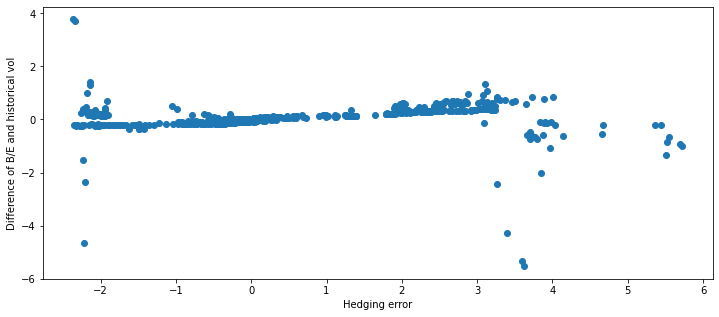

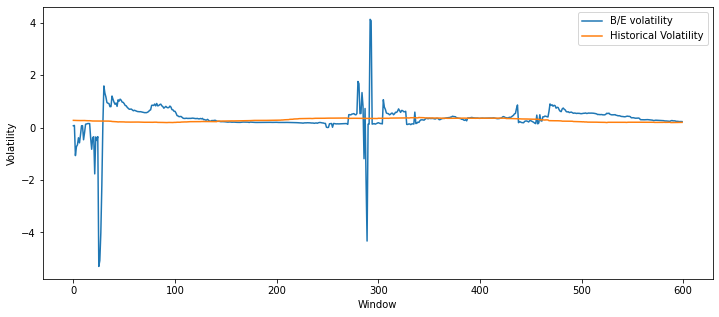

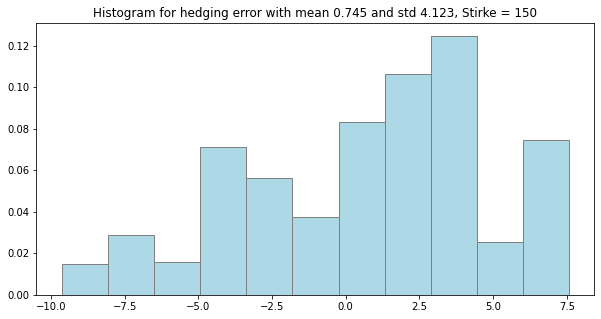

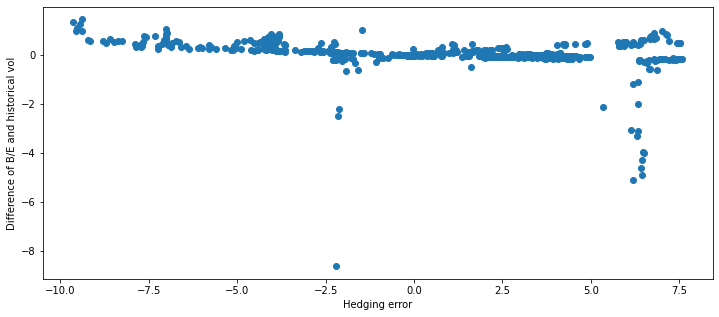

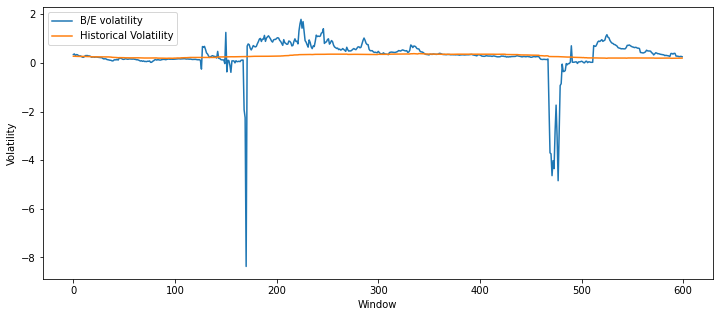

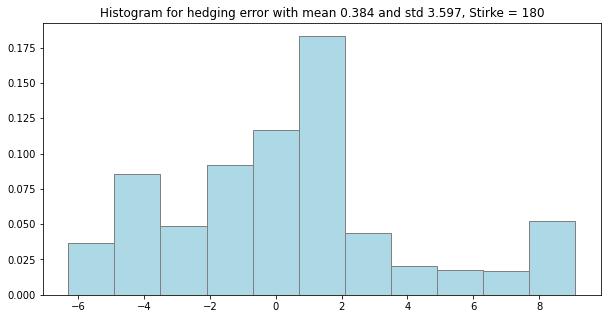

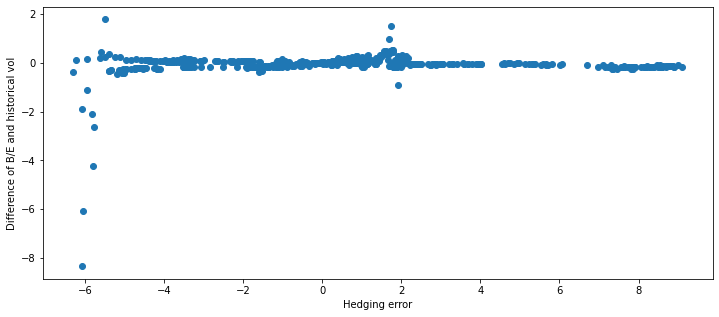

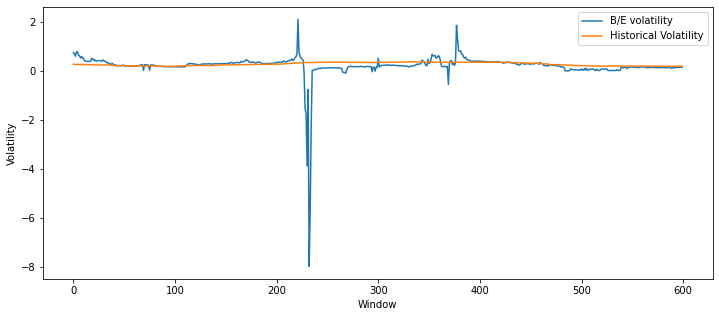

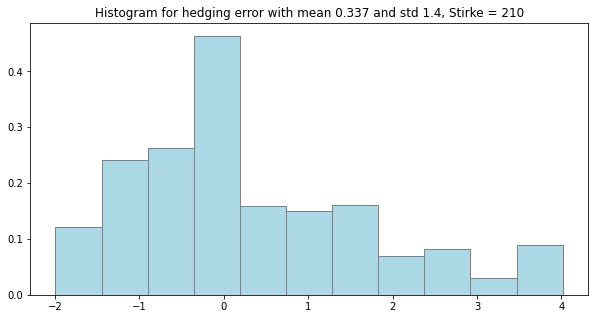

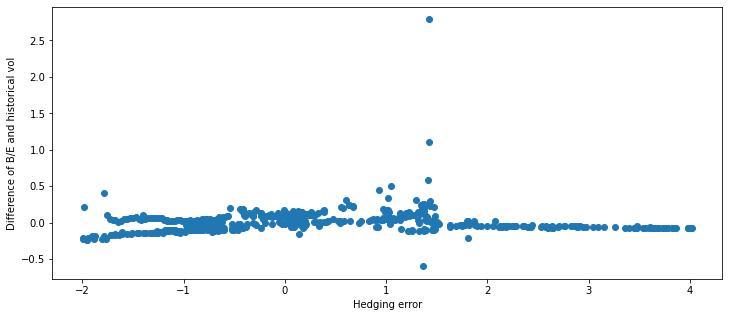

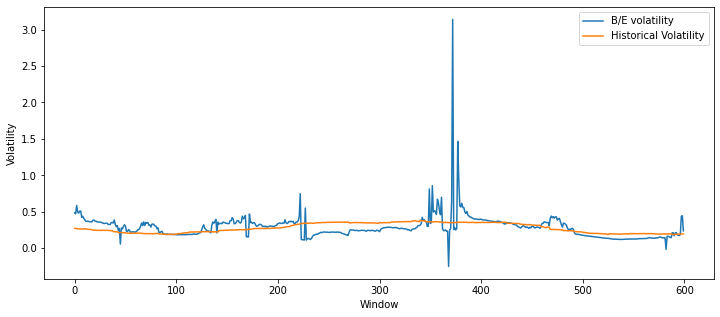

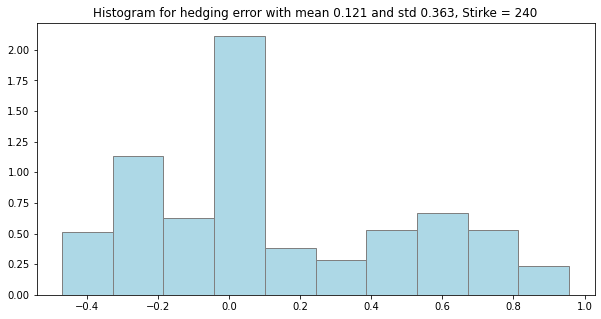

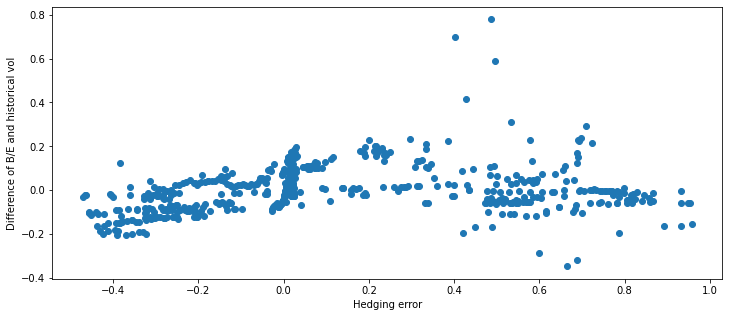

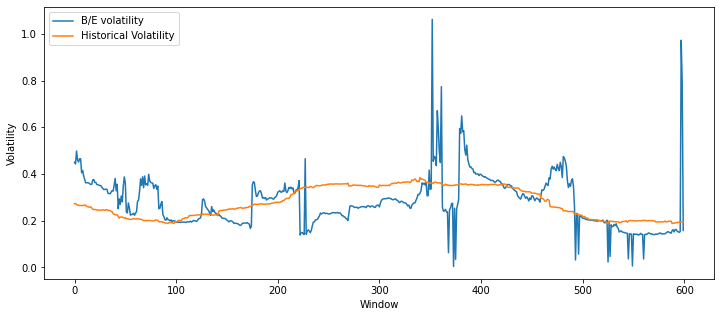

In [98]:
simulate_all(["ATM",120,150,180,210,240])

#### From the above plots, we can see that 
1) When applied to the real stock data, the mean and variance of the hedging error are larger than when the stock prices are simulated geometric brownian motions. This makes sense since the assumptions of BS model are violated;

2) Generally speaking, B/E volatility and Historical Volatility are very close and their difference wanders around zero;

3) Difference of B/E and historical vol seems to have no relationship with the hedging error;

4) We can see that sometimes the B/E volatility goes below zero, which means a perfect hedging is impossible;

5) There is not a clear pattern between the mean of hedging error and strike price.